In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

You should consider upgrading via the '/home/egor/PycharmProjects/deep_dr/venv/bin/python -m pip install --upgrade pip' command.


/home/egor/PycharmProjects/deep_dr/venv/lib/python3.10/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [1]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/egor/PycharmProjects/deep_dr/venv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0
/home/egor/PycharmProjects/deep_dr/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/egor/PycharmProjects/deep_dr/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` i

In [4]:
adata = scvi.data.heart_cell_atlas_subsampled()

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [5]:
sc.pp.filter_genes(adata, min_counts=3)

In [6]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source"
)

In [8]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"]
)

In [9]:
model = scvi.model.SCVI(adata)

In [10]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.9196, 0.2307, 0.4294],
        [0.5314, 0.7069, 0.9340],
        [0.3787, 0.9601, 0.9100],
        [0.4536, 0.2426, 0.5164],
        [0.0261, 0.7002, 0.2302]])


In [11]:
import torch
torch.cuda.is_available()

True

In [12]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [13]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [07:35<00:00,  1.10s/it, loss=291, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:35<00:00,  1.14s/it, loss=291, v_num=1]


In [14]:
latent = model.get_latent_representation()

In [15]:
adata.obsm["X_scVI"] = latent

In [16]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [17]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.609250,0.024623,3.272016,0.014370,3.327875
GAGTCATTCTCCGTGT-1-HCAHeart8287128,4.337921,0.033964,0.746443,0.046594,9.714651
CCTCTGATCGTGACAT-1-HCAHeart7702881,4.675269,0.084569,3.584399,0.039542,2.467435
CGCCATTCATCATCTT-1-H0035_apex,0.423099,0.171239,1.380893,0.121768,6.551954
TCGTAGAGTAGGACTG-1-H0015_septum,0.518551,0.078772,0.481444,0.178416,8.284348


In [18]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [19]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

/home/egor/PycharmProjects/deep_dr/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


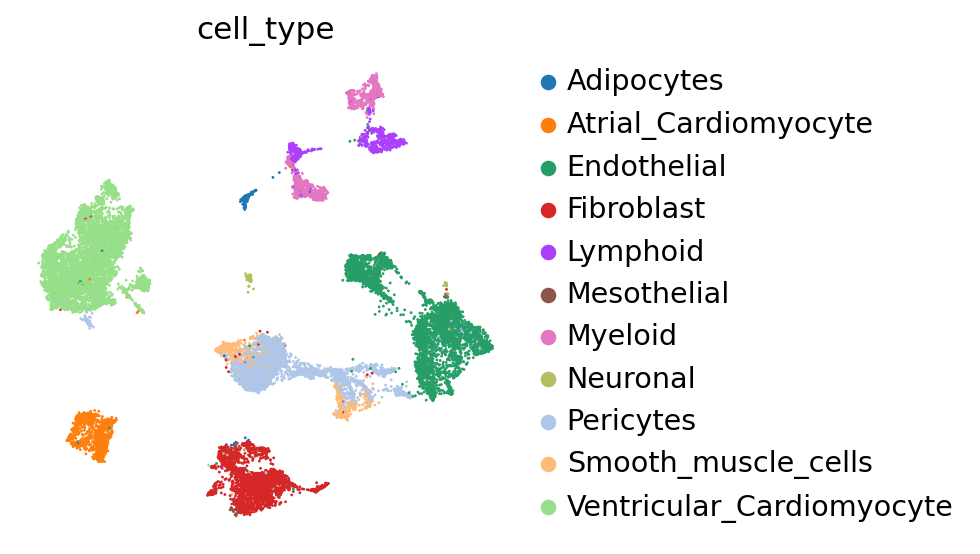

/home/egor/PycharmProjects/deep_dr/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/egor/PycharmProjects/deep_dr/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


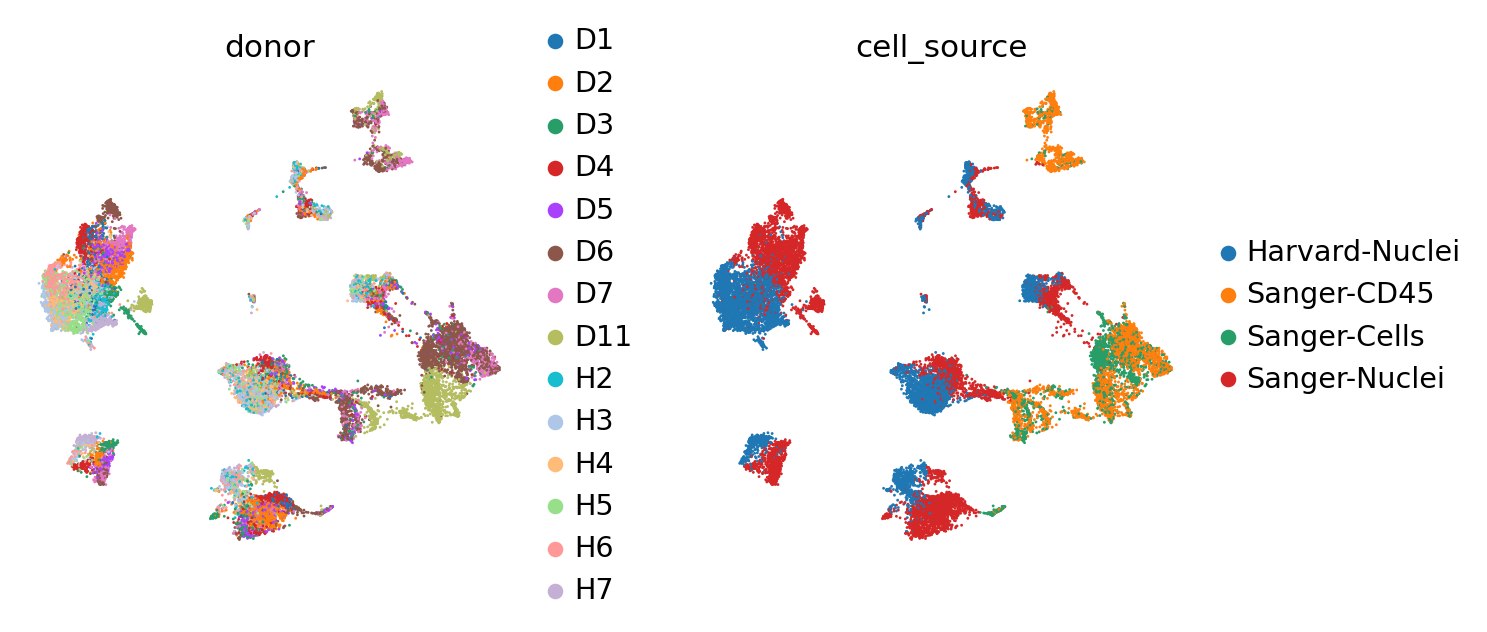

In [20]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)